Initial Data:
               area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  
Data after dropping unnecessary columns:
               area_type                  location       size total_sqft  bath  \
0  Super built-up  Area  Electronic City Phase II      2 BHK       1056   2.0   
1            Plot  Area 

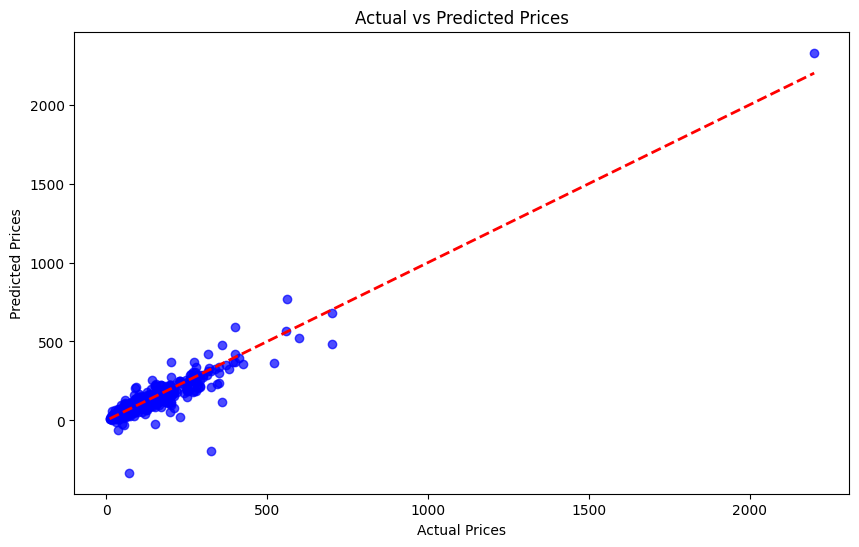

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import joblib
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'bengaluru_house_prices.csv'
data = pd.read_csv(file_path)
print("Initial Data:\n", data.head())

# Data preprocessing
# Dropping unnecessary columns
data = data.drop(['society', 'availability'], axis='columns')
print("Data after dropping unnecessary columns:\n", data.head())

# Handling missing values
data = data.dropna()
data['bhk'] = data['size'].apply(lambda x: int(x.split(' ')[0]))
print("Data after handling missing values and adding 'bhk':\n", data.head())

# Convert total_sqft to a numerical value
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

data['total_sqft'] = data['total_sqft'].apply(convert_sqft_to_num)
data = data[data['total_sqft'].notnull()]
print("Data after converting 'total_sqft' to numerical values:\n", data.head())

# Removing outliers
data = data[~(data.total_sqft / data.bhk < 300)]
data['price_per_sqft'] = data['price'] * 100000 / data['total_sqft']
print("Data after removing outliers and adding 'price_per_sqft':\n", data.head())

# Location preprocessing
data.location = data.location.apply(lambda x: x.strip())
location_stats = data.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats_less_than_10 = location_stats[location_stats <= 10]
data.location = data.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
print("Data after location preprocessing:\n", data.head())

# Save unique locations
unique_locations = data['location'].unique().tolist()
with open('unique_locations.pkl', 'wb') as f:
    joblib.dump(unique_locations, f)

# Removing more outliers
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

data = remove_pps_outliers(data)
print("Data after removing price per sqft outliers:\n", data.head())

# Remove BHK outliers
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk - 1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

data = remove_bhk_outliers(data)
print("Data after removing BHK outliers:\n", data.head())

# Final clean up
data = data[data.bath < data.bhk + 2]
data = data.drop(['size', 'price_per_sqft'], axis='columns')
print("Final cleaned data:\n", data.head())

# Encoding categorical data
data = pd.get_dummies(data, columns=['location', 'area_type'], drop_first=True)
print("Data after encoding categorical variables:\n", data.head())

# Split data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Save feature names
feature_names = X.columns.tolist()
with open('feature_names.pkl', 'wb') as f:
    joblib.dump(feature_names, f)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

# Create a pipeline with Polynomial Features and Ridge Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge(alpha=1.0))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

# Save the trained model
joblib.dump(pipeline, 'house_price_model.pkl')

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import joblib

# Load the dataset
file_path = 'bengaluru_house_prices.csv'
data = pd.read_csv(file_path)

# Data preprocessing
# Dropping unnecessary columns
data = data.drop(['society', 'availability'], axis='columns')

# Handling missing values
data = data.dropna()
data['bhk'] = data['size'].apply(lambda x: int(x.split(' ')[0]))

# Convert total_sqft to a numerical value
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

data['total_sqft'] = data['total_sqft'].apply(convert_sqft_to_num)
data = data[data['total_sqft'].notnull()]

# Removing outliers
data = data[~(data.total_sqft / data.bhk < 300)]
data['price_per_sqft'] = data['price'] * 100000 / data['total_sqft']

# Location preprocessing
data.location = data.location.apply(lambda x: x.strip())
location_stats = data.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats_less_than_10 = location_stats[location_stats <= 10]
data.location = data.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

# Save unique locations
unique_locations = data['location'].unique().tolist()
with open('unique_locations.pkl', 'wb') as f:
    joblib.dump(unique_locations, f)

# Removing more outliers
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

data = remove_pps_outliers(data)

# Remove BHK outliers
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk - 1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

data = remove_bhk_outliers(data)

# Final clean up
data = data[data.bath < data.bhk + 2]
data = data.drop(['size', 'price_per_sqft'], axis='columns')

# Encoding categorical data
data = pd.get_dummies(data, columns=['location', 'area_type'], drop_first=True)

# Split data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Save feature names
feature_names = X.columns.tolist()
with open('feature_names.pkl', 'wb') as f:
    joblib.dump(feature_names, f)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Create a pipeline with Polynomial Features and Ridge Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge(alpha=1.0))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

# Save the trained model
joblib.dump(pipeline, 'house_price_model.pkl')


R2 Score: 0.8718984639179737


['house_price_model.pkl']